# Seconde approche, la forêt aléatoire

Nous allons tester un modèle de random forest. Ce modèle est réputé plus évolué que le k-nn pour les problèmes de classification, d'autant plus pour les données catégorielles.

Comme pour le modèle précédent, nous importons les librairies et les données pré-traitées.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

train_data= pd.read_csv('data/pre_processing_train_data.csv')
train_data=train_data.iloc[:,1:]

train_sample=train_data.sample(n=10000)
train_labels=train_sample['Category']
train_sample.drop('Category',inplace =True, axis=1)   # remove the label from the train sample
train_sample.head()

,X,Y,Year,X_Bar_District,Y_Bar_District,Sin_Year,Cos_Year,Sin_Hour,Cos_Hour,Sin_Day_m,Cos_Day_m,Sin_Month,Cos_Month,Sin_Day_w,Cos_Day_w
544653,-122.435003,37.760888,-0.333333,-122.419409,37.759961,0.646124,-0.763232,7.071068e-01,-0.707107,0.937752,0.347305,-1.000000,-1.836970e-16,0.433884,-0.900969
409488,-122.451374,37.717699,0.000000,-122.477335,37.737549,-0.130526,-0.991445,1.224647e-16,-1.000000,-0.299363,-0.954139,-0.866025,-5.000000e-01,0.000000,1.000000
621026,-122.407376,37.779989,-0.500000,-122.405282,37.779915,0.130526,-0.991445,2.588190e-01,-0.965926,-0.937752,0.347305,-0.500000,-8.660254e-01,0.781831,0.623490
49247,-122.438303,37.803634,0.833333,-122.426647,37.786379,0.426569,-0.904455,5.000000e-01,-0.866025,-0.485302,-0.874347,-1.000000,-1.836970e-16,0.433884,-0.900969
296402,-122.404595,37.727376,0.333333,-122.393550,37.737256,-0.793353,0.608761,-8.660254e-01,0.500000,-0.790776,-0.612106,0.866025,-5.000000e-01,0.974928,-0.222521


Nous testons un premier modèle de forêt aléatoire.

In [10]:
# Load the model, loss and useful function
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss


X=train_sample
y=train_labels


# Split the training test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Fit a Random Forest model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
p_pred = clf.predict_proba(X_test)

print("The loss est de : ",log_loss(y_test,p_pred,labels=y_train.unique()))


The loss est de :  4.652439744737401


On veut faire une cross-validation de ce modèle. Les principaux paramètres sont : le nombre d'estimateurs, la profondeur maximale and le nombre minimal d'exemples par feuille. Nous choisirons dans un premier temps le nombre d'estimateurs indépendement des autres paramètres. En effet, le nombre d'arbre n'est pas corrélé avec leur profondeur au regard des résultats. Le nombre d'arbre garantit simplement une bonne qualité d'estimation.

Les deux autres paramètres : la profondeur maximale et le nombre minimal d'exemples par feuille, eux sont liés. Un point important ici est que la taille de l'ensemble d'entrainement est très grande (800 000 exemples) comparée à la taille de notre échantillon utilisé pour l'optimisation du modèle (10 000 échantillons). On fait cela pour diminuer le temps de calcul. Ainsi, choisir une profondeur maximale définitive en cross-validation obtenue sur un petit nombre d'exemples parait moins pertinent car on risquerait d'accumuler trop d'exemples encore séparables au niveau des feuilles et le modèle ne sera donc pasassez précis. Le seul choix du nombre minimal d'exemple par feuille détermine la profondeur moyenne des arbres et permet de garantir un modèle cohérent quelque soit la taille du dataset. En effet, pour un nombre d'échantillon $n$ et une profondeur $d$, le nombre d'exemples par feuille est d'environ  $\frac{n}{2^d}$. Ainsi, si on fixe le nombre minimum d'échantillon par feuille, on fixe quasiement la profondeur maximale.

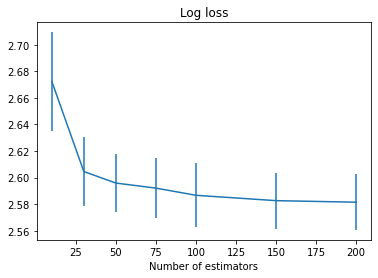

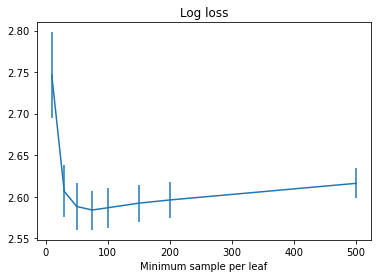

In [5]:
def cross_val_rdf_nb(X,y,nb_estimators=[10,50,100,150,200]):
    X=np.array(X)
    y=np.array(y)
    nb=len(nb_estimators)
    losses=[]
    for i in range(nb):
        loss=[]
        clf=RandomForestClassifier(n_estimators=nb_estimators[i],min_samples_leaf=100,random_state=42)
        for it in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y , random_state =it,     test_size=0.25)
            clf.fit(X_train,y_train)
            p_pred = clf.predict_proba(X_test)
            l=log_loss(y_test,p_pred,labels=np.unique(y_train))
            loss.append(l)
        losses.append(loss)
    losses=np.asarray(losses)
    plt.title("Log loss")
    plt.xlabel("Number of estimators")
    plt.errorbar(nb_estimators,losses.mean(axis=1),losses.std(axis=1))
    plt.show()

def cross_val_rdf_msl(X,y,msl_range=[10,50,100,200]):
    X=np.array(X)
    y=np.array(y)
    nb=len(msl_range)
    losses=[]
    for i in range(nb):
        loss=[]
        clf=RandomForestClassifier(n_estimators=100,min_samples_leaf=msl_range[i],random_state=42)
        for it in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y , random_state =it, test_size=0.25)
            clf.fit(X_train,y_train)
            p_pred = clf.predict_proba(X_test)
            l=log_loss(y_test,p_pred,labels=np.unique(y_train))
            loss.append(l)
        losses.append(loss)
    losses=np.asarray(losses)
    plt.title("Log loss")
    plt.xlabel("Minimum sample per leaf")
    plt.errorbar(msl_range,losses.mean(axis=1),losses.std(axis=1))
    plt.show()

cross_val_rdf_nb(X,y,nb_estimators=[10,30,50,75,100,150,200])
cross_val_rdf_msl(X,y,msl_range=[10,30,50,75,100,150,200,500])


On observe qu'un nombre de 150 arbres garantit un bon compromis entre précision et temps de calcul et qu'un nombre minimum de 100 exemples par feuille est optimal dans notre problème. On peut alors l'entrainer sur notre ensemble d'entraînement entier, obtenir les prédictions de l'ensemble test et enregistrer les résultats pour les analyser sur kaagle.

In [6]:
train_labels=train_data['Category']
train_data.drop('Category',inplace =True, axis=1)   # remove the label from the train sample

clf = RandomForestClassifier(n_estimators=150,min_samples_leaf=100)
clf.fit(train_data, train_labels)

test_data= pd.read_csv('data/pre_processing_test_data.csv')
test_data=test_data.iloc[:,1:]
list_cat=np.load('categories.npy',allow_pickle=True)

p_pred = clf.predict_proba(test_data)
pred= pd.DataFrame (p_pred, columns = list_cat)
pred.to_csv("pred_rdf.csv")

Ce modèle améliore grandement notre résultat. De 4.26, on passe à 2.42 en log loss, ce qui nous placerait 500-ième sur les 2500 groupes de la compétition.